In [1]:
import sys

sys.path.append("../functions")

from Utils import *
from Plotting import *
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.spatial import distance
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
# from sklearn.linear_model import LinearRegression
# import seaborn as sns
import warnings
import seaborn
import seaborn as sns
from sklearn.linear_model import LinearRegression
import scipy.stats
from scipy.special import logsumexp
from itertools import product
from functools import partial
from multiprocessing import Pool


In [91]:
raw_data = pd.read_csv("../data/twoArmedandit_with_confidence.csv")
data = raw_data[["sub", "condition", "cresp", "resp", "cj","cor", "phase", "trial", "trial_rev","reward", "Lreward", "Hreward" ]]
chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]

# selecting portion of data with proper task
lv_induction_data = data[
    (data["phase"] == "induction")
    & (data["condition"] == "hc")
    & (~data["sub"].isin(chance_level_subjects))
]
subjects = lv_induction_data["sub"].unique()

In [120]:
## def logll
def get_states_prob_hsmm(dist_params, log_emmission_prob_seq, T, durations):
    
    D = len(durations)
    
    dist = scipy.stats.nbinom(*dist_params)
    transition_log = dist.logpmf(durations)
    transition_log = transition_log - logsumexp(transition_log)
    log_alpha = np.full((T+1, 2), -np.inf)
    log_alpha[0,:] = 1
    log_alpha[0,:] = log_alpha[0,:] - logsumexp(log_alpha[0,:])

    state_k_prob = np.zeros((T,2, D))

    for t, time in enumerate(range(1,T+1)):
        temp_d = np.zeros((2,D))
        for k, current_time in enumerate(durations):
            if current_time == 1:
                k_emmission_prob = 0
                d_emmission_prob = log_emmission_prob_seq[t,:, k]
            elif time - current_time <0 :
                k_emmission_prob = -np.inf
                d_emmission_prob = -np.inf
            else:
                k_emmission_prob = log_emmission_prob_seq[t-1,:, k-1]
                d_emmission_prob = log_emmission_prob_seq[t,:,k]

            state_k_prob[t,:,k] = k_emmission_prob + np.flip(log_alpha[time-current_time,:])
            temp_d[:,k] = d_emmission_prob + transition_log[k] + np.flip(log_alpha[time-current_time,:])
        log_alpha[time,:] = logsumexp(temp_d, axis=-1)

    state_log_probs = logsumexp(state_k_prob, axis = -1)
    sum_probs = logsumexp(state_log_probs, axis=1, keepdims=True)
    state_log_probs = state_log_probs - sum_probs
    state_probs = np.exp(state_log_probs)
    return state_probs

def sub_state_prob_hsmm(sub_id):
  
    sub_data = lv_induction_data[lv_induction_data["sub"] == subjects[sub_id]]
    T = len(sub_data)
    rewards = sub_data["reward"].to_numpy()*100
    actions = sub_data["resp"].to_numpy()

    log_emmision_prob = np.zeros((T, 2)) # T = 1 to 400
    high_reward_dist = scipy.stats.norm(60, 8)
    low_reward_dist = scipy.stats.norm(40, 8)

    log_emmision_prob[:,0] = low_reward_dist.logpdf(rewards) # low_reward
    log_emmision_prob[:,1] = high_reward_dist.logpdf(rewards) # high_reward


    durations = range(1,71)
    D = len(durations)


    log_emmission_prob_seq = np.zeros((T,2,D)) # time from t=1 to T(400), states,durations = (1,40),

    for t, time in enumerate(range(1,T+1)):
            for d, duration in enumerate(durations):
                if t-d < 0:
                    log_emmission_prob_seq[t,:,d] = -np.inf
                else:
                    log_emmission_prob_seq[t,0,d] = np.sum(log_emmision_prob[time-duration:time,1][actions[time-duration:time] == 0]) + \
                                                    np.sum(log_emmision_prob[time-duration:time,0][actions[time-duration:time] == 1])

                    log_emmission_prob_seq[t,1,d] = np.sum(log_emmision_prob[time-duration:time,0][actions[time-duration:time] == 0]) + \
                                        np.sum(log_emmision_prob[time-duration:time,1][actions[time-duration:time] == 1])
    
    p_range = np.linspace(0.01, 0.99, 16)  
    n_range = np.linspace(0.01, 100, 16)
    grid = list(product(n_range, p_range))
    
    func = partial(get_states_prob_hsmm, log_emmission_prob_seq= log_emmission_prob_seq, T = T, durations = durations)

    with Pool(128) as pool:
        results = pool.map(func, grid)

    return grid,results

In [123]:
def protected_log(x):
    return np.log((1e-200 / 2) + (1 - 1e-200) * x)

def calculate_mf_probs(params, resps, rewards):
    alpha, beta = params[:2]
    Q = np.array([0.5, 0.5])
    probabilities = np.zeros(len(resps))
    for t, (resp, reward) in enumerate(zip(resps, rewards)):
        choice_prob = softmax_func(Q, beta)
        probabilities[t] = choice_prob[resp]
        Q[resp] += alpha * (reward - Q[resp])
    return probabilities



def ll_mix_model(params, resps, rewards, mb_probs):
    gamma, alpha, beta = params
    
    mf_probs = calculate_mf_probs((alpha,beta), resps, rewards)
    mix_probs = gamma*mf_probs + (1-gamma)*mb_probs
    
    return -np.sum(protected_log(mix_probs))

def fit_n_times(n_fitting, params_ranges, func, func_args):
    results = [minimize(func, x0=[np.random.uniform(*r) for r in params_ranges], args=func_args, bounds=params_ranges) for _ in range(n_fitting)]
    best_result = min(results, key=lambda x: x.fun if x.success else np.inf)
    return best_result.x, best_result.fun



def process_fit(args):
    i, results, actions, rewards, T = args
    states_prob_hsmm = results[i]
    mb_probs = states_prob_hsmm[np.arange(T), actions]
    x, ll = fit_n_times(20, params_ranges=[[0,1],[0.01, 1], [0.01, 100]],
                         func=ll_mix_model, func_args=(actions, rewards, mb_probs))
    return ll, x

def get_ll_model(sub_id): 
    sub_data = lv_induction_data[lv_induction_data["sub"] == subjects[sub_id]]
    rewards = sub_data["reward"].to_numpy()
    actions = sub_data["resp"].to_numpy()
    T = len(actions)
    grid, results = sub_state_prob_hsmm(sub_id)
    
    args_list = [(i, results, actions, rewards, T) for i in range(len(results))]
    
    with Pool(60) as pool:
        results_parallel = pool.map(process_fit, args_list)
    
    neg_ll_seq, params = zip(*results_parallel)
    
    min_idx = np.argmin(neg_ll_seq)
    neg_ll = neg_ll_seq[min_idx]
    mf_x = params[min_idx]
    mb_x = grid[min_idx]
    
    return neg_ll, mf_x, mb_x


In [124]:
# Assuming `subjects` is defined somewhere in your code
results = []
for sub_id, subject in enumerate(subjects):
    print(sub_id)
    neg_ll, mf_x, mb_x = get_ll_model(sub_id)
    gamma, alpha, beta = mf_x
    n, p = mb_x
    
    results.append({
        "subject": subject,
        "neg_ll": neg_ll,
        "gamma": gamma,
        "alpha": alpha,
        "beta": beta,
        "n": n,
        "p": p
    })

df = pd.DataFrame(results)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53


In [125]:
df.to_csv("../results/forward_mix_df_2.csv", index=False)

In [257]:
mf_df = pd.read_csv("../results/forward_df.csv")
mb_df = pd.read_csv("../results/")

array([  0.17916891,   0.69830555, 100.        ])

In [127]:
res[np.arange(T), actions].shape

NameError: name 'T' is not defined

In [128]:
mb_res = []
T = 400
for sub_id, subject in enumerate(subjects):
    print("sub_id", sub_id)
    grid, results = sub_state_prob_hsmm(sub_id)
    
    sub_data = lv_induction_data[lv_induction_data["sub"] == subjects[sub_id]]
    rewards = sub_data["reward"].to_numpy()
    actions = sub_data["resp"].to_numpy()
    
    neg_ll_seq = []
    for res in results:
        probs = res[np.arange(T), actions]
        neg_ll_seq.append(-np.sum(protected_log(probs)))
    
    min_idx = np.argmin(neg_ll_seq)
    
    neg_ll = neg_ll_seq[min_idx]
    mb_x = grid[min_idx]

    n, p = mb_x
    
    mb_res.append({
        "subject": subject,
        "neg_ll": neg_ll,
        "n": n,
        "p": p
    })

mb_df = pd.DataFrame(mb_res)



sub_id 0
sub_id 1
sub_id 2
sub_id 3
sub_id 4
sub_id 5
sub_id 6
sub_id 7
sub_id 8
sub_id 9
sub_id 10
sub_id 11
sub_id 12
sub_id 13
sub_id 14
sub_id 15
sub_id 16
sub_id 17
sub_id 18
sub_id 19
sub_id 20
sub_id 21
sub_id 22
sub_id 23
sub_id 24
sub_id 25
sub_id 26
sub_id 27
sub_id 28
sub_id 29
sub_id 30
sub_id 31
sub_id 32
sub_id 33
sub_id 34
sub_id 35
sub_id 36
sub_id 37
sub_id 38
sub_id 39
sub_id 40
sub_id 41
sub_id 42
sub_id 43
sub_id 44
sub_id 45
sub_id 46
sub_id 47
sub_id 48
sub_id 49
sub_id 50
sub_id 51
sub_id 52
sub_id 53


In [133]:
mb_df.to_csv("../results/mb_forward_2.csv", index=False)

Statistics for mf and mb =260.0, p=3.261e-05
Statistics for mb and mix =5.0, p=2.153e-10
Statistics for mf and mix =700.0, p=7.144e-01
mean mf = 232.22
mean mb = 303.42
mean mix = 213.22


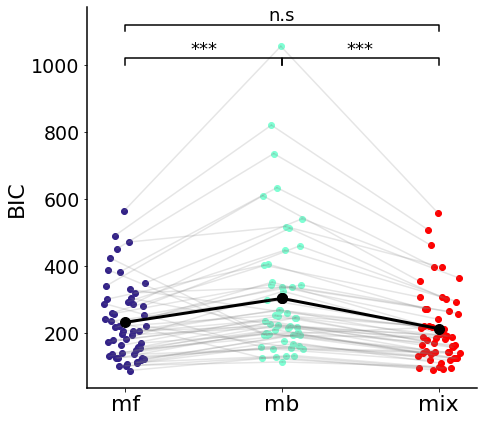

In [153]:
from Utils import *
from Plotting import *

mf_df = pd.read_csv("../results/forward_df.csv")
mf_df["bic"] = 2*mf_df["LL"] + 2*np.log(400)
mb_df = pd.read_csv("../results/mb_forward_2.csv")
mb_df["bic"] = 2*mb_df["neg_ll"] + 2*np.log(400)
mix_df = pd.read_csv("../results/forward_mix_df_2.csv")
mix_df["bic"] = 2*mix_df["neg_ll"] + 5*np.log(400)

groups = ["mf", "mb", "mix"]
merged_df = merge_result_df([mf_df, mb_df, mix_df], groups, 200, subjects)



color_dict = {"mb": "#7FFFD4", "mf": "#332288", "mix": "red"}

plt.figure(figsize=(7,7))
comparison_plot(
    merged_df,
    "bic",
    groups,
    "",
    [["mf", "mb"], ["mb", "mix"], ["mf", "mix"]],
    [1000, 1000, 1100],
    [20, 20, 20],
    y_label="BIC",
    color_dict = color_dict
)

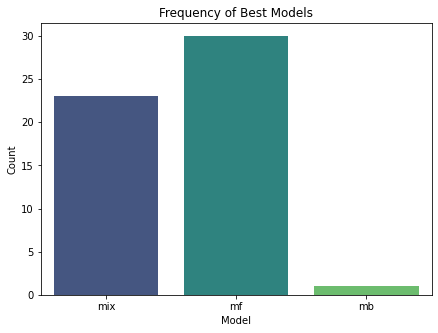

In [135]:
df_best_model = merged_df.loc[merged_df.groupby('subject')['bic'].idxmin()]
# Count the occurrences of each model
plt.figure(figsize=(7, 5))
sns.countplot(data=df_best_model, x="model", palette="viridis")

# Labels and title
plt.xlabel("Model")
plt.ylabel("Count")
plt.title("Frequency of Best Models")

# Show the plot
plt.show()

In [136]:
mix_df

,subject,neg_ll,gamma,alpha,beta,n,p,bic,model,x_idx
0,45628,50.705112,0.000000,1.000000,72.048720,93.334,0.794000,131.367546,mix,401
1,45640,33.293042,0.028682,0.709754,100.000000,93.334,0.794000,96.543406,mix,402
2,45664,162.226222,0.801474,1.000000,9.794989,80.002,0.859333,354.409767,mix,403
3,45682,138.495805,0.506184,1.000000,8.677566,100.000,0.859333,306.948933,mix,404
4,45745,92.815706,0.021031,0.010000,0.010000,86.668,0.794000,215.588735,mix,405
5,45760,66.960704,0.063912,0.289640,100.000000,13.342,0.467333,163.878730,mix,406
6,45763,54.670558,0.730966,1.000000,25.878685,6.676,0.336667,139.298438,mix,407
7,45805,78.865749,0.000000,1.000000,72.039025,86.668,0.794000,187.688820,mix,408
8,45829,95.710118,0.220831,1.000000,9.124666,80.002,0.794000,221.377559,mix,409
9,45964,120.770280,0.753955,0.840428,12.974794,100.000,0.859333,271.497882,mix,410


In [5]:
sub_data = lv_induction_data[lv_induction_data["sub"]  == subjects[0]] 
sub_data

,sub,condition,cresp,resp,cj,cor,phase,trial,trial_rev,reward,Lreward,Hreward
0,45628,hc,0,1,1.000000,0,induction,0,19,0.595649,59.564905,62.587240
1,45628,hc,0,0,1.000000,1,induction,1,18,0.531705,51.884986,53.170477
2,45628,hc,0,1,1.000000,0,induction,2,17,0.395744,39.574438,46.393013
3,45628,hc,0,0,1.000000,1,induction,3,16,0.657494,33.232232,65.749407
4,45628,hc,0,0,3.555556,1,induction,4,15,0.750121,44.238900,75.012120
...,...,...,...,...,...,...,...,...,...,...,...,...
395,45628,hc,1,1,5.000000,1,induction,17,4,0.552491,38.135791,55.249054
396,45628,hc,1,1,2.629630,1,induction,18,3,0.500389,41.569615,50.038923
397,45628,hc,1,1,2.068462,1,induction,19,2,0.489036,39.918200,48.903637
398,45628,hc,1,0,5.000000,0,induction,20,1,0.424627,42.462693,56.926954


/tmp/ipykernel_170826/4198073797.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(mix_df, x="gamma", palette="virdis")


<AxesSubplot:xlabel='gamma', ylabel='Count'>

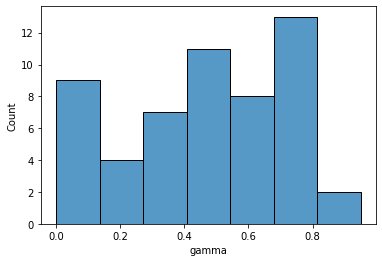

In [137]:
sns.histplot(mix_df, x="gamma", palette="virdis")

In [39]:
def simulate_mix_model(sub_data, params):
    
    alph,beta, gamma, n,p = params
    
    lrewards =  sub_data["Lreward"].to_numpy()
    hrewards = sub_data["Hreward"].to_numpy()
    cresps = sub_data["cresp"].to_numpy()
    
    
    T = len(cresps)
    
    # mf
    Q = np.array([0.5, 0.5])
    Q_list = np.zeros((T, 2))
    rewards = np.zeros(T)
    actions = np.zeros(T)
    chosen_probs = np.zeros(T)
    
    #mb
    durations = range(1,71)
    D = len(durations)
    
    dist = scipy.stats.nbinom(n,p)
    transition_log = dist.logpmf(durations)
    transition_log = transition_log - logsumexp(transition_log)
    log_alpha = np.full((T+1, 2), -np.inf)
    log_alpha[0,:] = 1
    log_alpha[0,:] = log_alpha[0,:] - logsumexp(log_alpha[0,:])
    log_emmision_prob = np.zeros((T, 2)) # T = 1 to 400
    high_reward_dist = scipy.stats.norm(60, 8)
    low_reward_dist = scipy.stats.norm(40, 8)
    state_k_prob = np.zeros((T,2, D))
    log_emmission_prob_seq = np.zeros((T,2,D)) # time from t=1 to T(400), states,durations = (1,40),

    

    acc = np.zeros(T)
    
    for t,time in enumerate(range(1,T+1)):
        #mf
        low_reward = lrewards[t]
        high_reward = hrewards[t]
        
        mf_probs = softmax_func(Q, beta) #mf prob
        
        #mb
        for k, current_time in enumerate(durations):
            if current_time == 1:
                k_emmission_prob = 0
            elif time - current_time <0 :
                k_emmission_prob = -np.inf
            else:
                k_emmission_prob = log_emmission_prob_seq[t-1,:, k-1]
            state_k_prob[t,:,k] = k_emmission_prob + np.flip(log_alpha[time-current_time,:])
            
        current_log_state = logsumexp(state_k_prob[t], axis = -1)
        current_log_state -= logsumexp(current_log_state, axis=-1)
        mb_probs = np.exp(current_log_state)
        
        # action 
        mix_probs = gamma*mf_probs + (1-gamma)*mb_probs
        resp = np.random.choice([0, 1], p=mix_probs)        
        
        if resp == cresps[t]:
            reward = hrewards[t]
            acc[t] = 1
        else:
            acc[t] = 0
            reward = lrewards[t]
        actions[t]= resp
        rewards[t]= reward
        
        #mf update
        prediction_error = reward/100 - Q[resp]
        Q[resp] = Q[resp] + alpha * prediction_error
        
        #mb update
        log_emmision_prob[t,0] = low_reward_dist.logpdf(reward)
        log_emmision_prob[t,1] = high_reward_dist.logpdf(reward)

        temp_d = np.zeros((2,D))
        for d, duration in enumerate(durations):
            if time - duration <0 :
                log_emmission_prob_seq[t,:,d] = -np.inf
                d_emmission_prob = -np.inf
            else:
                log_emmission_prob_seq[t,0,d] = np.sum(log_emmision_prob[time-duration:time,1][actions[time-duration:time] == 0]) + \
                                                np.sum(log_emmision_prob[time-duration:time,0][actions[time-duration:time] == 1])
                log_emmission_prob_seq[t,1,d] = np.sum(log_emmision_prob[time-duration:time,0][actions[time-duration:time] == 0]) + \
                                    np.sum(log_emmision_prob[time-duration:time,1][actions[time-duration:time] == 1])

                d_emmission_prob = log_emmission_prob_seq[t,:,d]
            temp_d[:,d] = d_emmission_prob + transition_log[d] + np.flip(log_alpha[time-duration,:])
        log_alpha[time,:] = logsumexp(temp_d, axis=-1)

#     confs = linear_transform_on_array(chosen_probs, [0, 1], [lbound, hbound])
    return acc

    
    
    

In [138]:
mix_df = pd.read_csv("../results/forward_mix_df_2.csv")


In [79]:
sub_id = 6
sub_data = lv_induction_data[lv_induction_data["sub"] == subjects[sub_id]]
params = mix_df[mix_df["subject"] == subjects[sub_id]].iloc[0][["alpha","beta", "gamma", "n", "p"]]
acc = simulate_mix_model(sub_data, params)

In [139]:
def run_simulation(sub_id):
    """Function to run 120 simulations and compute the average ACC."""
    sub_data = lv_induction_data[lv_induction_data["sub"] == subjects[sub_id]]
    params = mix_df[mix_df["subject"] == subjects[sub_id]].iloc[0][["alpha","beta", "gamma", "n", "p"]]
    
    acc_values = [simulate_mix_model(sub_data, params) for _ in range(120)]
    avg_acc = np.mean(acc_values)
    
    return subjects[sub_id], avg_acc

num_subjects = len(subjects)  # Assuming subjects is a list

with Pool(processes=60) as pool:
    results = pool.map(run_simulation, range(num_subjects))

# Convert results into a DataFrame for better visualization
results_df = pd.DataFrame(results, columns=["Subject", "performance"])


In [104]:
forward_sim = pd.read_csv("../results/forward_simulation_df.csv")

In [159]:
mix_sim = results_df
mix_sim = mix_sim.rename(columns={"Subject": "subject"})

forward_avg = forward_sim.groupby("subject").mean("cor").reset_index()[["subject","cor"]].rename(columns={"cor": "performance"})

emp_avg = lv_induction_data.groupby("sub").mean("cor").reset_index()[["sub","cor"]] \
                                                      .rename(columns={"cor": "performance","sub":"subject"})



In [109]:
emp_avg

,subject,performacne,model,x_idx
0,45628,0.9500,emp,201
1,45640,0.9400,emp,202
2,45664,0.7450,emp,203
3,45682,0.8250,emp,204
4,45745,0.9325,emp,205
5,45760,0.8700,emp,206
6,45763,0.8525,emp,207
7,45805,0.9275,emp,208
8,45829,0.8950,emp,209
9,45964,0.8000,emp,210


paired
Statistics for mf and emp =7.0, p=2.407e-10
Statistics for emp and mix =343.0, p=5.822e-04
Statistics for mix and mf =0.0, p=1.626e-10
mean mf = 0.76
mean emp = 0.86
mean mix = 0.85


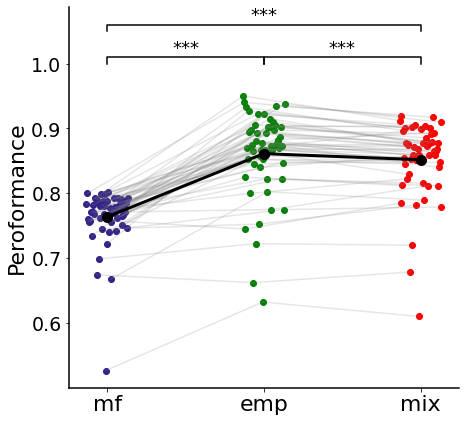

In [183]:
groups = ["mf", "emp", "mix"]
merged_df = merge_result_df([forward_avg, emp_avg, mix_sim], groups, 200, subjects)



color_dict = {"emp": "green", "mf": "#332288", "mix": "red"}

plt.figure(figsize=(7,7))
plt.title("paired test")
print("paired")
comparison_plot(
    merged_df,
    "performance",
    groups,
    "",
    [["mf", "emp"], ["emp", "mix"], ["mix", "mf"]],
    [1, 1, 1.05],
    [.01, .01, .01],
    y_label="Peroformance",
    color_dict = color_dict
)

non-paired test
Statistics for mf and emp =297.0, p=9.963e-13
Statistics for emp and mix =1697.0, p=1.428e-01
Statistics for mix and mf =2695.0, p=3.016e-14
mean mf = 0.76
mean emp = 0.86
mean mix = 0.85


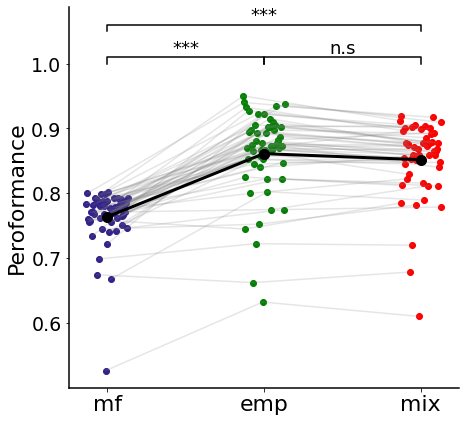

In [186]:
groups = ["mf", "emp", "mix"]
merged_df = merge_result_df([forward_avg, emp_avg, mix_sim], groups, 200, subjects)



color_dict = {"emp": "green", "mf": "#332288", "mix": "red"}

plt.figure(figsize=(7,7))
print("non-paired test")

comparison_plot(
    merged_df,
    "performance",
    groups,
    "",
    [["mf", "emp"], ["emp", "mix"], ["mix", "mf"]],
    [1, 1, 1.05],
    [.01, .01, .01],
    y_label="Peroformance",
    color_dict = color_dict
)

In [93]:
emp_avg = lv_induction_data.groupby("sub").mean("cor").reset_index()[["sub","cor"]] \
                                                      .rename(columns={"cor": "performacne","sub":"subject"})


<AxesSubplot:xlabel='performance', ylabel='Count'>

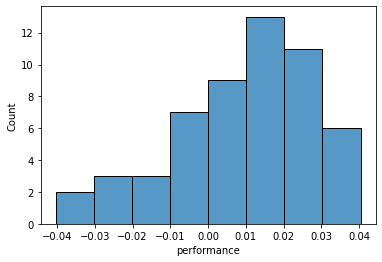

In [176]:

sns.histplot(emp_avg["performance"] - mix_sim["performance"])

In [185]:
color_dict = {"Backward": "#882255", "Forward": "#332288", "Empirical": "#117733"}
def comparison_plot(df, y_column, groups, titlestr="", s=[], y_list=[], h_list=[], legend="", y_label="",
                        var_df=pd.DataFrame(), color_dict = color_dict):
    

    for gr1, gr2 in zip(groups[:-1], groups[1:]):
        X_coords = np.array([df.query("model=='{}'".format(gr1)).x_idx,
                             df.query("model=='{}'".format(gr2)).x_idx])
        Y_coords = np.array([df.query("model=='{}'".format(gr1))[y_column],
                             df.query("model=='{}'".format(gr2))[y_column]])
        plt.plot(X_coords,
                 Y_coords,
                 color='gray',
                 alpha=.2)

        x_means = [df.query("model=='{}'".format(gr1)).x_idx.mean(), df.query("model=='{}'".format(gr2)).x_idx.mean()]
        y_means = [df.query("model=='{}'".format(gr1))[y_column].mean(),
                   df.query("model=='{}'".format(gr2))[y_column].mean()]
        plt.plot(x_means,
                 y_means,
                 marker='o',
                 linewidth=3, markersize=10, color="black")

    c = 0
    for gr1, gr2 in s:
        gr1_data = df.query("model=='{}'".format(gr1))
        gr2_data = df.query("model=='{}'".format(gr2))
        gr1_x_mean = gr1_data.x_idx.mean()
        gr2_x_mean = gr2_data.x_idx.mean()

        # stat, p = scipy.stats.ttest_ind(np.array(gr1_data[y_column]),np.array(gr2_data[y_column])).pvalue
        stat, p = scipy.stats.mannwhitneyu(np.array(gr1_data[y_column]), np.array(gr2_data[y_column]))
        print('Statistics for {} and {} ={}, p={:.3e}'.format(gr1, gr2,stat, p))
        symb = pval_symb(p)
        y = y_list[c]
        h = h_list[c]
        plt.plot([gr1_x_mean, gr1_x_mean, gr2_x_mean, gr2_x_mean], [y, y + h, y + h, y], lw=1.5, c="k")
        plt.text((gr1_x_mean + gr2_x_mean) / 2, y + h, symb, ha='center', va='bottom', fontsize=18)
        c += 1

    gr_xticks_ls = []
    for gr in groups:
        plt.scatter(df.query("model=='{}'".format(gr)).x_idx,
                    df.query("model=='{}'".format(gr))[y_column],
                    label=gr, c=color_dict[gr])
        gr_mean = df.query("model=='{}'".format(gr)).x_idx.mean()
        print("mean {} = {:.2f}".format(gr, df.query("model=='{}'".format(gr))[y_column].mean()))
        gr_xticks_ls.append(gr_mean)

    if not var_df.empty:
        for i, row in var_df.iterrows():
            line_pos = df[(df['subject'] == row["sub"]) & (df['model'] == "Low-Meta")]["x_idx"].iloc[0]
            line_mean = df[(df['subject'] == row["sub"]) & (df['model'] == "Low-Meta")][y_column].iloc[0]
            y_min = line_mean - row["cor"]
            y_max = line_mean + row["cor"]
            plt.vlines(x=line_pos, ymin=y_min, ymax=y_max, colors="#fc5252", alpha=.2)
            plt.hlines(y=y_min, xmin=line_pos - 1, xmax=line_pos + 1, colors="#fc5252", alpha=.2)
            plt.hlines(y=y_max, xmin=line_pos - 1, xmax=line_pos + 1, colors="#fc5252", alpha=.2)

    plt.title(titlestr, fontsize=12)
    plt.ylabel(y_label, fontsize=22)
    plt.yticks(fontsize=19)
    plt.xticks(fontsize=22)
    ax = plt.gca()
    plt.xticks(gr_xticks_ls, groups)

    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)

    # hide x-axis
    # ax.get_xaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)

(p = 8.31e-08, r = -0.65,ci = [-0.78,-0.47])


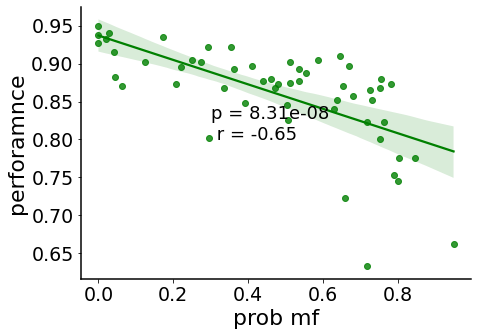

In [171]:
plt.figure(figsize=(7,5))
temp_df = emp_avg.merge(mix_df, on="subject")
temp_df2 = mix_sim.merge(mix_df, on="subject")
plot_regression_df(temp_df,"gamma", "performance", "green", .3, .8, "prob mf", "perforamnce")
# plot_regression_df(temp_df2,"gamma", "performance", "red", .3, .8, "prob mf", "perforamnce")

In [167]:
temp_df2

NameError: name 'temp_df2' is not defined